In [1]:
from collections import defaultdict
from functools import partial
from multiprocessing import cpu_count
from pathlib import Path
from textwrap import dedent
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.optim.lr_scheduler import _LRScheduler
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.dataset import Dataset
seed = 1
np.random.seed(seed)
ROOT = Path.cwd()
print(ROOT)
# enc = joblib.load(ROOT/'encoder.model')
raw_arr = np.load(ROOT/'feat.npy').transpose(0, 2, 1)
fft_arr = np.load(ROOT/'feat_fft.npy').transpose(0, 2, 1)
target = np.load(ROOT/'target.npy')
# print(dedent(f'''
# Dataset shapes:
#     raw: {raw_arr.shape}
#     fft: {fft_arr.shape}
#     target: {target.shape}
# '''))


def create_datasets(data, target, train_size, valid_pct=0.1, seed=None):
    """Converts NumPy arrays into PyTorch datsets.

    Three datasets are created in total:
        * training dataset
        * validation dataset
        * testing (un-labelled) dataset

    """
    raw, fft = data
    assert len(raw) == len(fft)
    sz = train_size

    print('sz', sz, 'raw.shape', raw.shape, 'target.shape', target.shape)
    idx = np.arange(sz)
    trn_idx, val_idx = train_test_split(
        idx, test_size=valid_pct, random_state=seed)
    print('trn_idx.shape', trn_idx.shape, 'trn_idx.shape', trn_idx.shape,)
    trn_ds = TensorDataset(
        torch.tensor(raw[:sz][trn_idx]).float(),
        torch.tensor(fft[:sz][trn_idx]).float(),
        torch.tensor(target[:sz][trn_idx]).long())
    val_ds = TensorDataset(
        torch.tensor(raw[:sz][val_idx]).float(),
        torch.tensor(fft[:sz][val_idx]).float(),
        torch.tensor(target[:sz][val_idx]).long())
    tst_ds = TensorDataset(
        torch.tensor(raw[sz:]).float(),
        torch.tensor(fft[sz:]).float(),
        torch.tensor(target[sz:]).long())
    return trn_ds, val_ds, tst_ds


def create_loaders(data, bs=128, jobs=0):
    """Wraps the datasets returned by create_datasets function with data loaders."""

    trn_ds, val_ds, tst_ds = data
    trn_dl = DataLoader(trn_ds, batch_size=bs, shuffle=True, num_workers=jobs)
    val_dl = DataLoader(val_ds, batch_size=bs, shuffle=False, num_workers=jobs)
    tst_dl = DataLoader(tst_ds, batch_size=bs, shuffle=False, num_workers=jobs)
    return trn_dl, val_dl, tst_dl


class _SepConv1d(nn.Module):
    """A simple separable convolution implementation.

    The separable convlution is a method to reduce number of the parameters
    in the deep learning network for slight decrease in predictions quality.
    """

    def __init__(self, ni, no, kernel, stride, pad):
        super().__init__()
        self.depthwise = nn.Conv1d(ni, ni, kernel, stride, padding=pad, groups=ni)
        self.pointwise = nn.Conv1d(ni, no, kernel_size=1)

    def forward(self, x):
        return self.pointwise(self.depthwise(x))


class SepConv1d(nn.Module):
    """Implementes a 1-d convolution with 'batteries included'.

    The module adds (optionally) activation function and dropout layers right after
    a separable convolution layer.
    """

    def __init__(self, ni, no, kernel, stride, pad, drop=None,
                 activ=lambda: nn.ReLU(inplace=True)):

        super().__init__()
        assert drop is None or (0.0 < drop < 1.0)
        layers = [_SepConv1d(ni, no, kernel, stride, pad)]
        if activ:
            layers.append(activ())
        if drop is not None:
            layers.append(nn.Dropout(drop))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)


class Flatten(nn.Module):
    """Converts N-dimensional tensor into 'flat' one."""

    def __init__(self, keep_batch_dim=True):
        super().__init__()
        self.keep_batch_dim = keep_batch_dim

    def forward(self, x):
        if self.keep_batch_dim:
            return x.view(x.size(0), -1)
        return x.view(-1)


class Classifier_dh(nn.Module):
    def __init__(self, raw_ni, no, drop=0.05):
        super().__init__()
        self.conv1 = SepConv1d(raw_ni, 32, 8, 2, 3, drop=drop)
        self.conv2 = SepConv1d(32, 64, 8, 4, 2, drop=drop)
        self.conv3 = SepConv1d(64, 128, 8, 4, 2, drop=drop)
        self.conv4 = SepConv1d(128, 256, 8, 4, 2)
        self.flatten = Flatten()
        self.fc1 = nn.Sequential(nn.Dropout(drop), nn.Linear(256, 64), nn.ReLU(inplace=True))
        self.fc2 = nn.Sequential(nn.Dropout(drop), nn.Linear(64, 64), nn.ReLU(inplace=True))
        self.out = nn.Sequential(
            nn.Linear(64, 64), nn.ReLU(inplace=True), nn.Linear(64, no))

    def forward(self, t_raw):
#         print('input size', t_raw.size())
        x = self.conv1(t_raw)
#         print('conv1', x.size())
        x = self.conv2(x)
#         print('conv2', x.size())
        x = self.conv3(x)
#         print('conv3', x.size())
        x = self.conv4(x)
#         print('conv4', x.size())
        x = self.flatten(x)
#         print('flatten', x.size())
        x = self.fc1(x)
#         print('fc1', x.size())
        x = self.fc2(x)
#         print('fc2', x.size())
        x = self.out(x)
        return x


def load_sensor_data(fname):
    sensor_txt = np.genfromtxt(fname, delimiter=',', dtype=None, encoding=None)
    # a 2-4 w 6-8 Angle 10-12 h 14-16 q 18-21
    # a 0-2 w 3-5 Angle 6-8   h 9-11  q 12-15
    row_len = 3*4 + 4
    data_length = len(sensor_txt)
    sensor_array = np.zeros((data_length, row_len))
    for row_i, sensor_row in enumerate(sensor_txt):
        # a 2-4
        sensor_array[row_i, 0] = sensor_row[2]
        sensor_array[row_i, 1] = sensor_row[3]
        sensor_array[row_i, 2] = sensor_row[4]
        # w 6-8
        sensor_array[row_i, 3] = sensor_row[6]
        sensor_array[row_i, 4] = sensor_row[7]
        sensor_array[row_i, 5] = sensor_row[8]
        # Angle 10-12
        sensor_array[row_i, 6] = sensor_row[10]
        sensor_array[row_i, 7] = sensor_row[11]
        sensor_array[row_i, 8] = sensor_row[12]
        # h 14-16
        sensor_array[row_i, 9] = sensor_row[14]
        sensor_array[row_i, 10] = sensor_row[15]
        sensor_array[row_i, 11] = sensor_row[16]
        # q 18-21
        sensor_array[row_i, 12] = sensor_row[18]
        sensor_array[row_i, 13] = sensor_row[19]
        sensor_array[row_i, 14] = sensor_row[20]
        sensor_array[row_i, 15] = sensor_row[21]
    return sensor_array

# class MyCustomDataset(Dataset):
#     def __init__(self):
#     # stuff
#     def __getitem__(self, index):
#         # stuff
#         return (img, label)

#     def __len__(self):
#         return count  # of how many examples(images?) you have

C:\Users\zhjsc\Desktop\zongyuan\sensor\repos\time_series_network


In [2]:
# generate sensor dataset
# 9533: talk -> eat -> read -> drink 20mins in total 5 mins for each action
def sample_sensor_data(input_data, window_sz = 128, sample_sz = 130):
    sensor_length = input_data.shape[0]
    print('The shape of sensor input data', input_data.shape)
    feature_sz = input_data.shape[1]
    data_sz = 0
    print('the length of sensor', sensor_length)
    for i in range(0, sensor_length-window_sz-sample_sz, sample_sz):
        data_sz = data_sz + 1
    all_sensor_data = np.zeros((data_sz, feature_sz, window_sz))
    cnt = 0
    for i in range(0, sensor_length-window_sz-sample_sz, sample_sz):
        sample = input_data[i:i + window_sz, :]
        sample = np.transpose(sample)
        all_sensor_data[cnt, :, :] = sample
        cnt = cnt + 1
    print('the shape of sensor dataset', all_sensor_data.shape)
    return all_sensor_data 
# processed_head_9533 = sample_sensor_data(head_9533)

In [1]:
import matplotlib.pyplot as plt
head_9533_with_h = load_sensor_data(fname='sensor_data_v2\sensor\head-9533.txt')
xarray = np.asarray([i for i in range(len(head_9533_with_h[:, 1]))])
for j in range(16):
    plt.plot(xarray, head_9533_with_h[:, j])
    plt.ylabel(str(j))
    plt.show()
# plt.show()


NameError: name 'load_sensor_data' is not defined

In [4]:
def load_sensor_data_without_h(fname):
    sensor_txt = np.genfromtxt(fname, delimiter=',', dtype=None, encoding=None)
    # a 2-4 w(augular velocity) 6-8 Angle 10-12 h 14-16 q(quaternion) 18-21
    # a 0-2 w 3-5 Angle 6-8 q 9 10 11 12
    row_len = 3*3 + 4
    data_length = len(sensor_txt)
    sensor_array = np.zeros((data_length, row_len))
    for row_i, sensor_row in enumerate(sensor_txt):
        # a 2-4
        sensor_array[row_i, 0] = sensor_row[2]
        sensor_array[row_i, 1] = sensor_row[3]
        sensor_array[row_i, 2] = sensor_row[4]
        # w 6-8
        sensor_array[row_i, 3] = sensor_row[6]
        sensor_array[row_i, 4] = sensor_row[7]
        sensor_array[row_i, 5] = sensor_row[8]
        # Angle 10-12
        sensor_array[row_i, 6] = sensor_row[10]
        sensor_array[row_i, 7] = sensor_row[11]
        sensor_array[row_i, 8] = sensor_row[12]
        # q 18-21
        sensor_array[row_i, 9] = sensor_row[18]
        sensor_array[row_i, 10] = sensor_row[19]
        sensor_array[row_i, 11] = sensor_row[20]
        sensor_array[row_i, 12] = sensor_row[21]
    return sensor_array

In [5]:
# 9533: talk -> eat -> read -> drink 20mins in total 5 mins for each action
head_9533 = load_sensor_data_without_h(fname='sensor_data_v2\sensor\head-9533.txt')
all_sensor_data = sample_sensor_data(head_9533)

The shape of sensor input data (18216, 13)
the length of sensor 18216
the shape of sensor dataset (139, 13, 128)


In [6]:
# generate labels for 9533
# counter for text on/look at a cellphone
sensor_length = head_9533.shape[0]
total_action = 4
window_sz = 128
sample_sz = 130
action_cnt = int(sensor_length / 4)
action_remain_cnt = sensor_length - action_cnt * (total_action-1)
label = np.concatenate((np.repeat(0, action_cnt),
                        np.repeat(1, action_cnt),
                        np.repeat(2, action_cnt),
                        np.repeat(3, action_remain_cnt)))
all_label = np.zeros((all_sensor_data.shape[0], 1)) 
cnt = 0
from collections import Counter
for i in range(0, sensor_length-window_sz-sample_sz, sample_sz):
    label_array = label[i:i + window_sz]
#     print(label_array)
    counter_label_array = Counter(label_array)
    cur_label = counter_label_array.most_common(1)[0][0]
    all_label[cnt] = cur_label
    cnt = cnt + 1
# print(all_label.shape)
# print(all_label)
# print(sensor_length)

In [7]:
# 9534:  9mins in total 3 mins for each action
head_9534 = load_sensor_data_without_h(fname='sensor_data_v2\sensor\head-9534.txt')
all_sensor_data_part2 = sample_sensor_data(head_9534)

The shape of sensor input data (8740, 13)
the length of sensor 8740
the shape of sensor dataset (66, 13, 128)


In [8]:
# generate labels for 9534
sensor_length = head_9534.shape[0]
total_action = 3
window_sz = 128
sample_sz = 130
action_cnt = int(sensor_length / 3)
action_remain_cnt = sensor_length - action_cnt * (total_action-1)
label = np.concatenate((np.repeat(4, action_cnt),
                        np.repeat(5, action_cnt),
                        np.repeat(6, action_remain_cnt)))
all_label_part2 = np.zeros((all_sensor_data_part2.shape[0], 1)) 
cnt = 0
from collections import Counter
for i in range(0, sensor_length-window_sz-sample_sz, sample_sz):
    label_array = label[i:i + window_sz]
#     print(label_array)
    counter_label_array = Counter(label_array)
    cur_label = counter_label_array.most_common(1)[0][0]
    all_label_part2[cnt] = cur_label
    cnt = cnt + 1
# print(all_label_part2)

In [9]:
# 9535:  10 min one action work on the computer 
head_9535 = load_sensor_data_without_h(fname='sensor_data_v2\sensor\head-9535.txt')
all_sensor_data_part3 = sample_sensor_data(head_9535)
sensor_length = head_9535.shape[0]
total_action = 3
window_sz = 128
sample_sz = 130
action_cnt = int(sensor_length / 3)
# action_remain_cnt = sensor_length - action_cnt * (total_action-1)
label = np.repeat(7, action_cnt)
all_label_part3 = np.zeros((all_sensor_data_part3.shape[0], 1)) 
cnt = 0
from collections import Counter
for i in range(0, sensor_length-window_sz-sample_sz, sample_sz):
    all_label_part3[cnt] = 7
    cnt = cnt + 1
# print(all_label_part3)

The shape of sensor input data (9121, 13)
the length of sensor 9121
the shape of sensor dataset (69, 13, 128)


In [10]:
combine_flag = True
if combine_flag:
    combine_label = np.concatenate((all_label, all_label_part2, all_label_part3))
    combine_data = np.concatenate((all_sensor_data, all_sensor_data_part2, all_sensor_data_part3))
    print(combine_label.shape)
    valid_pct = 0.2
    sz = combine_label.shape[0] 
    idx = np.arange(sz)
    bs = 4
    trn_idx, val_idx = train_test_split(idx, test_size=valid_pct, random_state=seed)
    print(combine_data.shape)
    trn_ds = TensorDataset(torch.tensor(combine_data[trn_idx]).float(), torch.tensor(combine_label[trn_idx]).long())
    trn_dl = DataLoader(trn_ds, batch_size=bs, shuffle=True, num_workers=0)
    val_ds = TensorDataset(torch.tensor(combine_data[val_idx]).float(), torch.tensor(combine_label[val_idx]).long())
    val_dl = DataLoader(val_ds, batch_size=bs, shuffle=True, num_workers=0)
else:
    valid_pct = 0.2
    sz = all_label.shape[0] 
    idx = np.arange(sz)
    bs = 4
    trn_idx, val_idx = train_test_split(idx, test_size=valid_pct, random_state=seed)
    print(all_sensor_data.shape)
    trn_ds = TensorDataset(torch.tensor(all_sensor_data[trn_idx]).float(), torch.tensor(all_label[trn_idx]).long())
    trn_dl = DataLoader(trn_ds, batch_size=bs, shuffle=True, num_workers=0)
    val_ds = TensorDataset(torch.tensor(all_sensor_data[val_idx]).float(), torch.tensor(all_label[val_idx]).long())
    val_dl = DataLoader(val_ds, batch_size=bs, shuffle=True, num_workers=0)
    print(len(trn_ds))

(274, 1)
(274, 13, 128)


In [11]:
# xarray = np.asarray([i for i in range(len(head_9533[:, 1]))])
# for j in range(13):
#     plt.plot(xarray, head_9533_noh[:, j])
#     plt.ylabel(str(j))
#     plt.show()

In [14]:
import torch as tf
lr = 0.001
n_epochs = 1000
iterations_per_epoch = len(trn_ds)
num_classes = 8
best_acc = 0
patience, trials = 500, 0
base = 1
step = 2
loss_history = []
acc_history = []
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = Classifier_dh(combine_data.shape[1], num_classes).to(device)
criterion = nn.CrossEntropyLoss(reduction='sum')
opt = optim.Adam(model.parameters(), lr=lr)
print('Start model training')

for epoch in range(1, n_epochs + 1):
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(trn_dl):
        x_raw, y_batch = [t.to(device) for t in batch]
        opt.zero_grad()
        out = model(x_raw)
        y_batch = tf.squeeze(y_batch)
        loss = criterion(out, y_batch)
        epoch_loss += loss.item()
        loss.backward()
        opt.step()

    loss_history.append(epoch_loss)
    model.eval()
    correct, total = 0, 0
    for batch in val_dl:
        x_raw, y_batch = [t.to(device) for t in batch]
        y_batch = tf.squeeze(y_batch)
        out = model(x_raw)
        preds = F.log_softmax(out, dim=1).argmax(dim=1)
#         print(preds, y_batch)
        total += y_batch.size(0)
        correct += (preds == y_batch).sum().item()

    acc = correct / total
    acc_history.append(acc)
    if epoch % base == 0:
        print(f'Epoch: {epoch:3d}. Loss: {epoch_loss:.4f}. Acc.: {acc:2.2%}')
        base *= step

    if acc > best_acc:
        trials = 0
        best_acc = acc
        torch.save(model.state_dict(), 'best.pth')
        print(f'Epoch {epoch} best model saved with accuracy: {best_acc:2.2%}')
    else:
        trials += 1
        if trials >= patience:
            print(f'Early stopping on epoch {epoch}')
            break

Start model training
Epoch:   1. Loss: 451.6041. Acc.: 25.45%
Epoch 1 best model saved with accuracy: 25.45%
Epoch:   2. Loss: 434.4486. Acc.: 27.27%
Epoch 2 best model saved with accuracy: 27.27%
Epoch 3 best model saved with accuracy: 36.36%
Epoch:   4. Loss: 278.0463. Acc.: 49.09%
Epoch 4 best model saved with accuracy: 49.09%
Epoch 6 best model saved with accuracy: 63.64%
Epoch:   8. Loss: 181.3758. Acc.: 54.55%
Epoch 15 best model saved with accuracy: 65.45%
Epoch:  16. Loss: 125.9316. Acc.: 65.45%
Epoch 17 best model saved with accuracy: 67.27%
Epoch 24 best model saved with accuracy: 69.09%
Epoch 25 best model saved with accuracy: 78.18%
Epoch 28 best model saved with accuracy: 80.00%
Epoch:  32. Loss: 78.8243. Acc.: 78.18%
Epoch 34 best model saved with accuracy: 83.64%
Epoch:  64. Loss: 5.4493. Acc.: 78.18%
Epoch 76 best model saved with accuracy: 85.45%
Epoch: 128. Loss: 45.3311. Acc.: 76.36%
Epoch 133 best model saved with accuracy: 87.27%
Epoch 153 best model saved with acc

In [1]:
128*256

32768

In [16]:
18216/128

142.3125

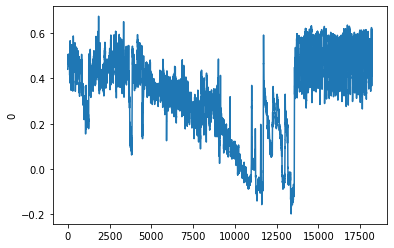

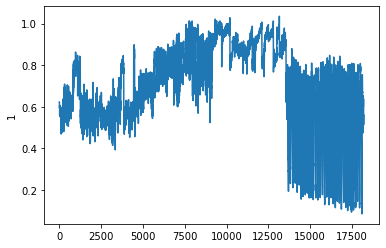

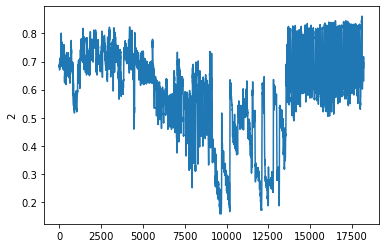

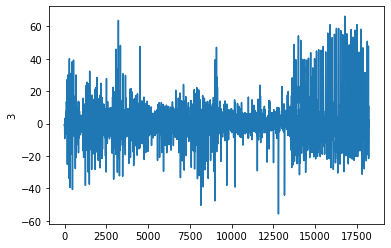

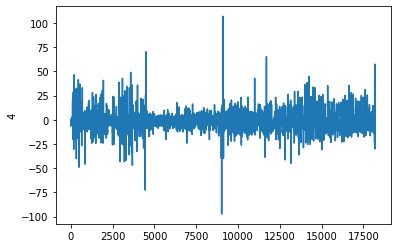

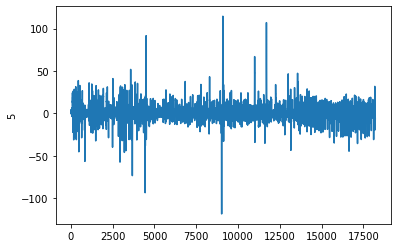

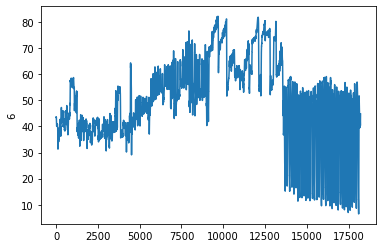

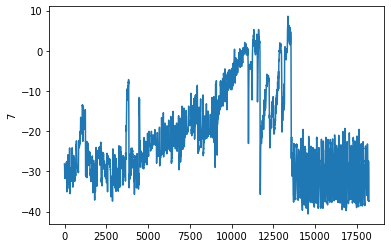

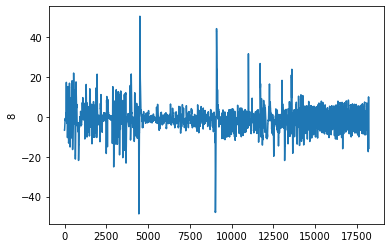

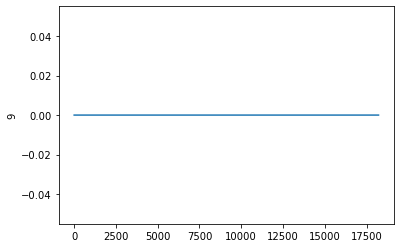

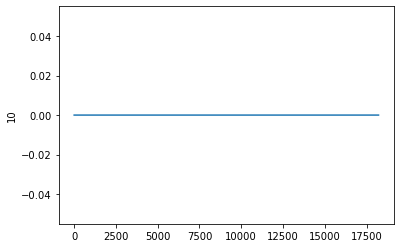

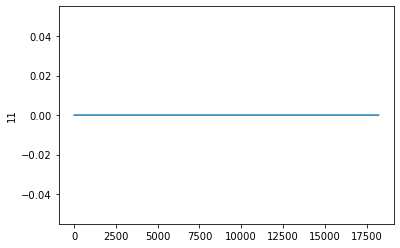

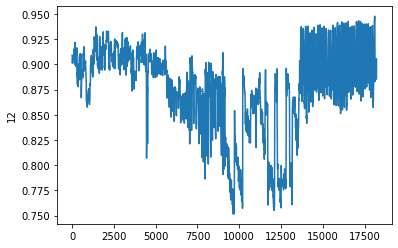

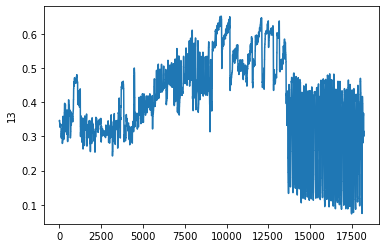

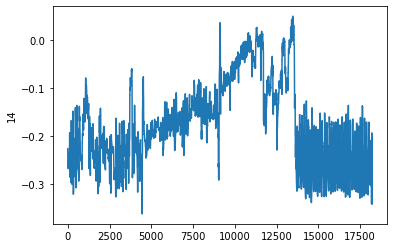

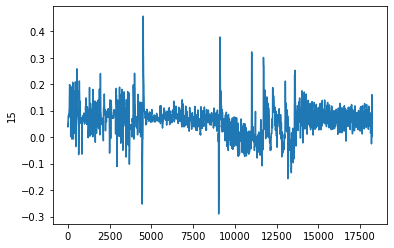

In [22]:
import matplotlib.pyplot as plt
head_9533_with_h = load_sensor_data('sensor_data_v2\sensor\head-9533.txt')
xarray = np.asarray([i for i in range(len(head_9533_with_h[:, 1]))])
for j in range(16):
    plt.plot(xarray, head_9533_with_h[:, j])
    plt.ylabel(str(j))
    plt.show()